<a href="https://colab.research.google.com/github/juliohsu/house-prediction-reg/blob/main/house_prediction_reg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'house-prices-advanced-regression-techniques:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F5407%2F868283%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240924%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240924T232312Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dae42fbda1ae94a97aebcf325d4a91153f54b971e06c8b3590b49f82d68f85768b1fa617f823c4b2adb48d6c5bcf3af6907cdb8c97345e0c5cde8fe853322ae2978880d2a4c0c96f59f1dd1bdc81cf15aef28e1e0a8d9a06e972f36d5bac21f6efd756ea6d16f85895e26fa74a9fd713b82de1bab9f3f3896d4a09cf8cb7a60afea85a3425cc0e4dbb809512a542dc67dbd433e4dc1e96e80c11a6822c0a05960f4f31d641f4f1cd6e7069c498c66fccf9dc9e0de43df27ff71e4f744ffcb0d43344f043fc7ed68e549349160f29be09bb710ce1940c57918171ed0ce0ceed4b065ad56f93429be67d6d8be0cf3b5875e79941acc0975197eea09e133100dd181'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 203809 bytes downloaded
Downloaded and uncompressed: house-prices-advanced-regression-techniques
Data source import complete.


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/test.csv
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv


# Data Visualization & Exploration

In [4]:
import pandas as pd

# load dataset
X = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
X_test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

In [5]:
# overview dataframe and its types
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [6]:
# overview train dataframe and its values
pd.set_option('display.max_columns', None)
X.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
X_test.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,NaN,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


# Data Preprocessing (Handle Missing Value)

In [8]:
# show percentage of features missing values
cat_missing = X.isnull().sum()
cat_total = X.isnull().count()
cat_miss_percent = cat_missing / cat_total
df_missing = pd.DataFrame(
    cat_miss_percent,
    columns=['Missing Value']
).sort_values(
    by='Missing Value',
    ascending=False
)

df_missing.head(20)

,Missing Value
PoolQC,0.995205
MiscFeature,0.963014
Alley,0.937671
Fence,0.807534
MasVnrType,0.597260
FireplaceQu,0.472603
LotFrontage,0.177397
GarageYrBlt,0.055479
GarageCond,0.055479
GarageType,0.055479


In [9]:
# drop some of the most missing values features columns
most_miss_col = df_missing[df_missing['Missing Value'] > 0.06].index
#X = X.drop(columns=most_miss_col)
#X_test = X_test.drop(columns=most_miss_col)

X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

In [10]:
# select numeric features
num_col = X.select_dtypes(exclude=['object'])

num_col.isnull().sum().sort_values(ascending=False).head(20)

,0
LotFrontage,259
GarageYrBlt,81
MasVnrArea,8
Id,0
OpenPorchSF,0
KitchenAbvGr,0
TotRmsAbvGrd,0
Fireplaces,0
GarageCars,0
GarageArea,0


In [11]:
from sklearn.impute import SimpleImputer

# convert numeric features nan values into mean values
num_imputer = SimpleImputer(strategy='median')
num_imputer.fit(num_col)
num_impute_train = num_imputer.transform(num_col)
num_col = pd.DataFrame(num_impute_train, columns=num_col.columns)
X[num_col.columns] = num_col
X_test[num_col.columns] = num_col

num_col.isnull().sum().sort_values(ascending=False).head(20)

,0
Id,0
WoodDeckSF,0
BedroomAbvGr,0
KitchenAbvGr,0
TotRmsAbvGrd,0
Fireplaces,0
GarageYrBlt,0
GarageCars,0
GarageArea,0
OpenPorchSF,0


In [12]:
# select categorical feature
cat_col = X.select_dtypes(include=['object'])

cat_col.isnull().sum().sort_values(ascending=False).head(20)

,0
PoolQC,1453
MiscFeature,1406
Alley,1369
Fence,1179
MasVnrType,872
FireplaceQu,690
GarageType,81
GarageCond,81
GarageQual,81
GarageFinish,81


In [13]:
# convert categorical features nan values into mode values
cat_imputer = SimpleImputer(strategy='most_frequent')
cat_imputer.fit(cat_col)
cat_impute_train = cat_imputer.transform(cat_col)
cat_col = pd.DataFrame(cat_impute_train, columns=cat_col.columns)
X[cat_col.columns] = cat_col
X_test[cat_col.columns] = cat_col

cat_col.isnull().sum().sort_values(ascending=False).head(20)

,0
MSZoning,0
FireplaceQu,0
BsmtFinType1,0
BsmtFinType2,0
Heating,0
HeatingQC,0
CentralAir,0
Electrical,0
KitchenQual,0
Functional,0


In [14]:
# check for the dataset
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   float64
 1   MSSubClass     1459 non-null   float64
 2   MSZoning       1459 non-null   object 
 3   LotFrontage    1459 non-null   float64
 4   LotArea        1459 non-null   float64
 5   Street         1459 non-null   object 
 6   Alley          1459 non-null   object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1459 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   float64
 18  OverallC


# Data Preprocessing (Feature Engineering)

In [15]:
# overview dataset again to remove unnecessary features
X

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1.0,60.0,RL,65.0,8450.0,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7.0,5.0,2003.0,2003.0,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856.0,854.0,0.0,1710.0,1.0,0.0,2.0,1.0,3.0,1.0,Gd,8.0,Typ,0.0,Gd,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0.0,61.0,0.0,0.0,0.0,0.0,Gd,MnPrv,Shed,0.0,2.0,2008.0,WD,Normal,208500.0
1,2.0,20.0,RL,80.0,9600.0,Pave,Grvl,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6.0,8.0,1976.0,1976.0,Gable,CompShg,MetalSd,MetalSd,BrkFace,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262.0,0.0,0.0,1262.0,0.0,1.0,2.0,0.0,3.0,1.0,TA,6.0,Typ,1.0,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298.0,0.0,0.0,0.0,0.0,0.0,Gd,MnPrv,Shed,0.0,5.0,2007.0,WD,Normal,181500.0
2,3.0,60.0,RL,68.0,11250.0,Pave,Grvl,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7.0,5.0,2001.0,2002.0,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920.0,866.0,0.0,1786.0,1.0,0.0,2.0,1.0,3.0,1.0,Gd,6.0,Typ,1.0,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0.0,42.0,0.0,0.0,0.0,0.0,Gd,MnPrv,Shed,0.0,9.0,2008.0,WD,Normal,223500.0
3,4.0,70.0,RL,60.0,9550.0,Pave,Grvl,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7.0,5.0,1915.0,1970.0,Gable,CompShg,Wd Sdng,Wd Shng,BrkFace,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961.0,756.0,0.0,1717.0,1.0,0.0,1.0,0.0,3.0,1.0,Gd,7.0,Typ,1.0,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0.0,35.0,272.0,0.0,0.0,0.0,Gd,MnPrv,Shed,0.0,2.0,2006.0,WD,Abnorml,140000.0
4,5.0,60.0,RL,84.0,14260.0,Pave,Grvl,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8.0,5.0,2000.0,2000.0,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145.0,1053.0,0.0,2198.0,1.0,0.0,2.0,1.0,4.0,1.0,Gd,9.0,Typ,1.0,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192.0,84.0,0.0,0.0,0.0,0.0,Gd,MnPrv,Shed,0.0,12.0,2008.0,WD,Normal,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456.0,60.0,RL,62.0,7917.0,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6.0,5.0,1999.0,2000.0,Gable,CompShg,VinylSd,VinylSd,BrkFace,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,953.0,953.0,GasA,Ex,Y,SBrkr,953.0,694.0,0.0,1647.0,0.0,0.0,2.0,1.0,3.0,1.0,TA,7.0,Typ,1.0,TA,Attchd,1999.0,RFn,2.0,460.0,TA,TA,Y,0.0,40.0,0.0,0.0,0.0,0.0,Gd,MnPrv,Shed,0.0,8.0,2007.0,WD,Normal,175000.0
1456,1457.0,20.0,RL,85.0,13175.0,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6.0,6.0,1978.0,1988.0,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790.0,Rec,163.0,589.0,1542.0,GasA,TA,Y,SBrkr,2073.0,0.0,0.0,2073.0,1.0,0.0,2.0,0.0,3.0,1.0,TA,7.0,Min1,2.0,TA,Attchd,1978.0,Unf,2.0,500.0,TA,TA,Y,349.0,0.0,0.0,0.0,0.0,0.0,Gd,MnPrv,Shed,0.0,2.0,2010.0,WD,Normal,210000.0
1457,14

In [16]:
# combining interesting features
def combine_features(df):
    df['TotalLivArea'] = df['GrLivArea'] + df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
    df['TotalBath'] = df['FullBath'] + (0.5 * df['HalfBath']) + df['BsmtFullBath'] + (0.5 * df['BsmtHalfBath'])
    df['GarageScore'] = df['GarageCars'] + df['GarageArea'] / 100
    return df

X = combine_features(X)
X_test = combine_features(X_test)

X

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TotalLivArea,TotalBath,GarageScore
0,1.0,60.0,RL,65.0,8450.0,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7.0,5.0,2003.0,2003.0,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856.0,854.0,0.0,1710.0,1.0,0.0,2.0,1.0,3.0,1.0,Gd,8.0,Typ,0.0,Gd,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0.0,61.0,0.0,0.0,0.0,0.0,Gd,MnPrv,Shed,0.0,2.0,2008.0,WD,Normal,208500.0,4276.0,3.5,7.48
1,2.0,20.0,RL,80.0,9600.0,Pave,Grvl,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6.0,8.0,1976.0,1976.0,Gable,CompShg,MetalSd,MetalSd,BrkFace,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262.0,0.0,0.0,1262.0,0.0,1.0,2.0,0.0,3.0,1.0,TA,6.0,Typ,1.0,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298.0,0.0,0.0,0.0,0.0,0.0,Gd,MnPrv,Shed,0.0,5.0,2007.0,WD,Normal,181500.0,3786.0,2.5,6.60
2,3.0,60.0,RL,68.0,11250.0,Pave,Grvl,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7.0,5.0,2001.0,2002.0,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920.0,866.0,0.0,1786.0,1.0,0.0,2.0,1.0,3.0,1.0,Gd,6.0,Typ,1.0,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0.0,42.0,0.0,0.0,0.0,0.0,Gd,MnPrv,Shed,0.0,9.0,2008.0,WD,Normal,223500.0,4492.0,3.5,8.08
3,4.0,70.0,RL,60.0,9550.0,Pave,Grvl,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7.0,5.0,1915.0,1970.0,Gable,CompShg,Wd Sdng,Wd Shng,BrkFace,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961.0,756.0,0.0,1717.0,1.0,0.0,1.0,0.0,3.0,1.0,Gd,7.0,Typ,1.0,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0.0,35.0,272.0,0.0,0.0,0.0,Gd,MnPrv,Shed,0.0,2.0,2006.0,WD,Abnorml,140000.0,4190.0,2.0,9.42
4,5.0,60.0,RL,84.0,14260.0,Pave,Grvl,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8.0,5.0,2000.0,2000.0,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145.0,1053.0,0.0,2198.0,1.0,0.0,2.0,1.0,4.0,1.0,Gd,9.0,Typ,1.0,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192.0,84.0,0.0,0.0,0.0,0.0,Gd,MnPrv,Shed,0.0,12.0,2008.0,WD,Normal,250000.0,5541.0,3.5,11.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456.0,60.0,RL,62.0,7917.0,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6.0,5.0,1999.0,2000.0,Gable,CompShg,VinylSd,VinylSd,BrkFace,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,953.0,953.0,GasA,Ex,Y,SBrkr,953.0,694.0,0.0,1647.0,0.0,0.0,2.0,1.0,3.0,1.0,TA,7.0,Typ,1.0,TA,Attchd,1999.0,RFn,2.0,460.0,TA,TA,Y,0.0,40.0,0.0,0.0,0.0,0.0,Gd,MnPrv,Shed,0.0,8.0,2007.0,WD,Normal,175000.0,4247.0,2.5,6.60
1456,1457.0,20.0,RL,85.0,13175.0,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6.0,6.0,1978.0,1988.0,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790.0,Rec,163.0,589.0,1542.0,GasA,TA,Y,SBrkr,2073.0,0.0,0.0,2073.0,1.0,0.0,2.0,0.0,

In [17]:
# overview dataset to check for unnecessary features
unnecessary_features = [
                        'Street', 'Utilities', 'LandSlope',
                        'Condition1', 'Condition2',
                        'RoofMatl', 'Exterior2nd', 'ExterCond',
                        'Heating', 'Electrical',
                        'MoSold', 'SaleCondition'
                       ]

X = X.drop(columns=unnecessary_features)
X_test = X_test.drop(columns=unnecessary_features)
X

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,Neighborhood,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,MasVnrType,MasVnrArea,ExterQual,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,YrSold,SaleType,SalePrice,TotalLivArea,TotalBath,GarageScore
0,1.0,60.0,RL,65.0,8450.0,Grvl,Reg,Lvl,Inside,CollgCr,1Fam,2Story,7.0,5.0,2003.0,2003.0,Gable,VinylSd,BrkFace,196.0,Gd,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,Ex,Y,856.0,854.0,0.0,1710.0,1.0,0.0,2.0,1.0,3.0,1.0,Gd,8.0,Typ,0.0,Gd,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0.0,61.0,0.0,0.0,0.0,0.0,Gd,MnPrv,Shed,0.0,2008.0,WD,208500.0,4276.0,3.5,7.48
1,2.0,20.0,RL,80.0,9600.0,Grvl,Reg,Lvl,FR2,Veenker,1Fam,1Story,6.0,8.0,1976.0,1976.0,Gable,MetalSd,BrkFace,0.0,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,Ex,Y,1262.0,0.0,0.0,1262.0,0.0,1.0,2.0,0.0,3.0,1.0,TA,6.0,Typ,1.0,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298.0,0.0,0.0,0.0,0.0,0.0,Gd,MnPrv,Shed,0.0,2007.0,WD,181500.0,3786.0,2.5,6.60
2,3.0,60.0,RL,68.0,11250.0,Grvl,IR1,Lvl,Inside,CollgCr,1Fam,2Story,7.0,5.0,2001.0,2002.0,Gable,VinylSd,BrkFace,162.0,Gd,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,Ex,Y,920.0,866.0,0.0,1786.0,1.0,0.0,2.0,1.0,3.0,1.0,Gd,6.0,Typ,1.0,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0.0,42.0,0.0,0.0,0.0,0.0,Gd,MnPrv,Shed,0.0,2008.0,WD,223500.0,4492.0,3.5,8.08
3,4.0,70.0,RL,60.0,9550.0,Grvl,IR1,Lvl,Corner,Crawfor,1Fam,2Story,7.0,5.0,1915.0,1970.0,Gable,Wd Sdng,BrkFace,0.0,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,Gd,Y,961.0,756.0,0.0,1717.0,1.0,0.0,1.0,0.0,3.0,1.0,Gd,7.0,Typ,1.0,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0.0,35.0,272.0,0.0,0.0,0.0,Gd,MnPrv,Shed,0.0,2006.0,WD,140000.0,4190.0,2.0,9.42
4,5.0,60.0,RL,84.0,14260.0,Grvl,IR1,Lvl,FR2,NoRidge,1Fam,2Story,8.0,5.0,2000.0,2000.0,Gable,VinylSd,BrkFace,350.0,Gd,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,Ex,Y,1145.0,1053.0,0.0,2198.0,1.0,0.0,2.0,1.0,4.0,1.0,Gd,9.0,Typ,1.0,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192.0,84.0,0.0,0.0,0.0,0.0,Gd,MnPrv,Shed,0.0,2008.0,WD,250000.0,5541.0,3.5,11.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456.0,60.0,RL,62.0,7917.0,Grvl,Reg,Lvl,Inside,Gilbert,1Fam,2Story,6.0,5.0,1999.0,2000.0,Gable,VinylSd,BrkFace,0.0,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,953.0,953.0,Ex,Y,953.0,694.0,0.0,1647.0,0.0,0.0,2.0,1.0,3.0,1.0,TA,7.0,Typ,1.0,TA,Attchd,1999.0,RFn,2.0,460.0,TA,TA,Y,0.0,40.0,0.0,0.0,0.0,0.0,Gd,MnPrv,Shed,0.0,2007.0,WD,175000.0,4247.0,2.5,6.60
1456,1457.0,20.0,RL,85.0,13175.0,Grvl,Reg,Lvl,Inside,NWAmes,1Fam,1Story,6.0,6.0,1978.0,1988.0,Gable,Plywood,Stone,119.0,TA,CBlock,Gd,TA,No,ALQ,790.0,Rec,163.0,589.0,1542.0,TA,Y,2073.0,0.0,0.0,2073.0,1.0,0.0,2.0,0.0,3.0,1.0,TA,7.0,Min1,2.0,TA,Attchd,1978.0,Unf,2.0,500.0,TA,TA,Y,349.0,0.0,0.0,0.0,0.0,0.0,Gd,MnPrv,Shed,0.0,2010.0,WD,210000.0,5688.0,3.0,7.00
1457,1458.0,70.0,RL,66.0,9042.0,Grvl,Reg,Lvl,Inside,Crawfor,1Fam,2Story,7.0,9.0,1941.0,2006.0,Gable,CemntBd,BrkFace,0.0,Ex,Stone,TA,Gd,No,GLQ,275.0,Unf,0.0,877.0,1152.0,Ex,Y,1188.0,1152.0,0.0,2340.0,0.0,0.0,2.0,0.0,4.0,1.0,Gd,9.0,Typ,2.0,Gd,Attchd,1941.0,RFn,1.0,252.0,TA,TA,Y,0.0,60.0,0.0,0.0,0.0,0.0,Gd,GdPrv,Shed,2500.0,2010.0,WD,266500.0,5832.0,2.0,3.52
1458,1459.0,20.0,RL,68.0,9717.0,Grvl,Reg,Lvl,Inside,NAmes,1Fam,1Story,5.0,6.0,1950.0,1996.0,Hip,MetalSd,BrkFace,0.0,TA,CBlock,TA,

In [18]:
# categorical overview target feature correlation
cat_col = X.select_dtypes(include=['object'])

In [19]:
# numeric overview target feature correlation
corr_X = X.corr(numeric_only=True)
corr_Xtarget = corr_X['SalePrice']

corr_Xtarget

,SalePrice
Id,-0.021917
MSSubClass,-0.084284
LotFrontage,0.334771
LotArea,0.263843
OverallQual,0.790982
OverallCond,-0.077856
YearBuilt,0.522897
YearRemodAdd,0.507101
MasVnrArea,0.472614
BsmtFinSF1,0.386420


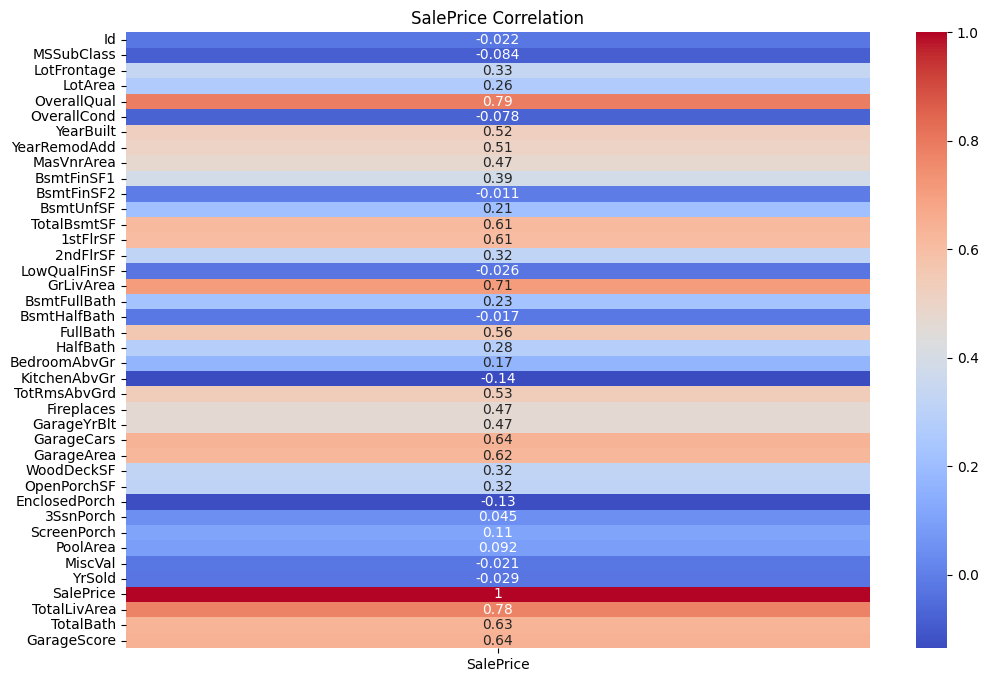

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# plot target feature correlation
plt.figure(figsize=(12, 8))
sns.heatmap(corr_X[['SalePrice']], annot=True, cmap='coolwarm')
plt.title('SalePrice Correlation')
plt.show()

In [21]:
# filter out unnecessary features columns
unnecessary_col = corr_Xtarget[abs(corr_Xtarget) < 0.1].index.tolist()
X = X.drop(columns=unnecessary_col)
X_test = X_test.drop(columns=unnecessary_col)
X

,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,Neighborhood,BldgType,HouseStyle,OverallQual,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,MasVnrType,MasVnrArea,ExterQual,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,PoolQC,Fence,MiscFeature,SaleType,SalePrice,TotalLivArea,TotalBath,GarageScore
0,RL,65.0,8450.0,Grvl,Reg,Lvl,Inside,CollgCr,1Fam,2Story,7.0,2003.0,2003.0,Gable,VinylSd,BrkFace,196.0,Gd,PConc,Gd,TA,No,GLQ,706.0,Unf,150.0,856.0,Ex,Y,856.0,854.0,1710.0,1.0,2.0,1.0,3.0,1.0,Gd,8.0,Typ,0.0,Gd,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0.0,61.0,0.0,0.0,Gd,MnPrv,Shed,WD,208500.0,4276.0,3.5,7.48
1,RL,80.0,9600.0,Grvl,Reg,Lvl,FR2,Veenker,1Fam,1Story,6.0,1976.0,1976.0,Gable,MetalSd,BrkFace,0.0,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,284.0,1262.0,Ex,Y,1262.0,0.0,1262.0,0.0,2.0,0.0,3.0,1.0,TA,6.0,Typ,1.0,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298.0,0.0,0.0,0.0,Gd,MnPrv,Shed,WD,181500.0,3786.0,2.5,6.60
2,RL,68.0,11250.0,Grvl,IR1,Lvl,Inside,CollgCr,1Fam,2Story,7.0,2001.0,2002.0,Gable,VinylSd,BrkFace,162.0,Gd,PConc,Gd,TA,Mn,GLQ,486.0,Unf,434.0,920.0,Ex,Y,920.0,866.0,1786.0,1.0,2.0,1.0,3.0,1.0,Gd,6.0,Typ,1.0,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0.0,42.0,0.0,0.0,Gd,MnPrv,Shed,WD,223500.0,4492.0,3.5,8.08
3,RL,60.0,9550.0,Grvl,IR1,Lvl,Corner,Crawfor,1Fam,2Story,7.0,1915.0,1970.0,Gable,Wd Sdng,BrkFace,0.0,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,540.0,756.0,Gd,Y,961.0,756.0,1717.0,1.0,1.0,0.0,3.0,1.0,Gd,7.0,Typ,1.0,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0.0,35.0,272.0,0.0,Gd,MnPrv,Shed,WD,140000.0,4190.0,2.0,9.42
4,RL,84.0,14260.0,Grvl,IR1,Lvl,FR2,NoRidge,1Fam,2Story,8.0,2000.0,2000.0,Gable,VinylSd,BrkFace,350.0,Gd,PConc,Gd,TA,Av,GLQ,655.0,Unf,490.0,1145.0,Ex,Y,1145.0,1053.0,2198.0,1.0,2.0,1.0,4.0,1.0,Gd,9.0,Typ,1.0,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192.0,84.0,0.0,0.0,Gd,MnPrv,Shed,WD,250000.0,5541.0,3.5,11.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,62.0,7917.0,Grvl,Reg,Lvl,Inside,Gilbert,1Fam,2Story,6.0,1999.0,2000.0,Gable,VinylSd,BrkFace,0.0,TA,PConc,Gd,TA,No,Unf,0.0,Unf,953.0,953.0,Ex,Y,953.0,694.0,1647.0,0.0,2.0,1.0,3.0,1.0,TA,7.0,Typ,1.0,TA,Attchd,1999.0,RFn,2.0,460.0,TA,TA,Y,0.0,40.0,0.0,0.0,Gd,MnPrv,Shed,WD,175000.0,4247.0,2.5,6.60
1456,RL,85.0,13175.0,Grvl,Reg,Lvl,Inside,NWAmes,1Fam,1Story,6.0,1978.0,1988.0,Gable,Plywood,Stone,119.0,TA,CBlock,Gd,TA,No,ALQ,790.0,Rec,589.0,1542.0,TA,Y,2073.0,0.0,2073.0,1.0,2.0,0.0,3.0,1.0,TA,7.0,Min1,2.0,TA,Attchd,1978.0,Unf,2.0,500.0,TA,TA,Y,349.0,0.0,0.0,0.0,Gd,MnPrv,Shed,WD,210000.0,5688.0,3.0,7.00
1457,RL,66.0,9042.0,Grvl,Reg,Lvl,Inside,Crawfor,1Fam,2Story,7.0,1941.0,2006.0,Gable,CemntBd,BrkFace,0.0,Ex,Stone,TA,Gd,No,GLQ,275.0,Unf,877.0,1152.0,Ex,Y,1188.0,1152.0,2340.0,0.0,2.0,0.0,4.0,1.0,Gd,9.0,Typ,2.0,Gd,Attchd,1941.0,RFn,1.0,252.0,TA,TA,Y,0.0,60.0,0.0,0.0,Gd,GdPrv,Shed,WD,266500.0,5832.0,2.0,3.52
1458,RL,68.0,9717.0,Grvl,Reg,Lvl,Inside,NAmes,1Fam,1Story,5.0,1950.0,1996.0,Hip,MetalSd,BrkFace,0.0,TA,CBlock,TA,TA,Mn,GLQ,49.0,Rec,0.0,1078.0,Gd,Y,1078.0,0.0,1078.0,1.0,1.0,0.0,2.0,1.0,Gd,5.0,Typ,0.0,Gd,Attchd,1950.0,Unf,1.0,240.0,TA,TA,Y,366.0,0.0,112.0,0.0,Gd,MnPrv,Shed,WD,142125.0,3234.0,2.0,3.40


# Data Preprocessing (Data Transformation)

In [22]:
import numpy as np

# separate the target feature and reduce its skewness
y = X['SalePrice']
X = X.drop(columns=['SalePrice'])
y = np.log1p(y)
y

,SalePrice
0,12.247699
1,12.109016
2,12.317171
3,11.849405
4,12.429220
...,...
1455,12.072547
1456,12.254868
1457,12.493133
1458,11.864469


# Data Preprocessing (Data Scaling)

In [23]:
# check for the dataset its types
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 61 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSZoning       1460 non-null   object 
 1   LotFrontage    1460 non-null   float64
 2   LotArea        1460 non-null   float64
 3   Alley          1460 non-null   object 
 4   LotShape       1460 non-null   object 
 5   LandContour    1460 non-null   object 
 6   LotConfig      1460 non-null   object 
 7   Neighborhood   1460 non-null   object 
 8   BldgType       1460 non-null   object 
 9   HouseStyle     1460 non-null   object 
 10  OverallQual    1460 non-null   float64
 11  YearBuilt      1460 non-null   float64
 12  YearRemodAdd   1460 non-null   float64
 13  RoofStyle      1460 non-null   object 
 14  Exterior1st    1460 non-null   object 
 15  MasVnrType     1460 non-null   object 
 16  MasVnrArea     1460 non-null   float64
 17  ExterQual      1460 non-null   object 
 18  Foundati

In [24]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# identify numeric and categorical features
numFT_X = X.select_dtypes(include=['int64', 'float64']).columns
catFT_X = X.select_dtypes(exclude=['int64', 'float64']).columns

# pipeline for data scaling
scaling = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numFT_X),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), catFT_X)
    ]
)

# Data Splitting

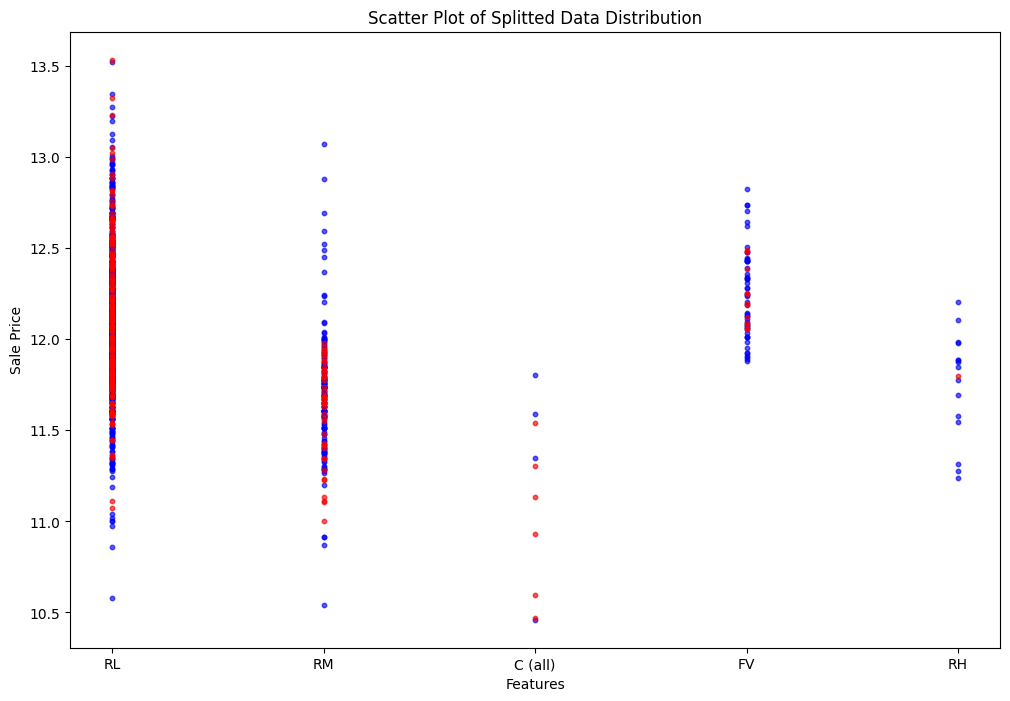

In [25]:
from sklearn.model_selection import train_test_split

# let's split the dataset 80% training and 20% validation
bins = pd.cut(y, bins=5, labels=False)
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.80, random_state=42)

# plot splitted data
plt.figure(figsize=(12, 8))
plt.scatter(X.iloc[:,0], y, color='gray', alpha=0.2, label='Original Data', s=10)
plt.scatter(X_train.iloc[:,0], y_train, color='blue', alpha=0.6, label='Training Data', s=10)
plt.scatter(X_val.iloc[:,0], y_val, color='red', alpha=0.6, label='Validation Data', s=10)

plt.title('Scatter Plot of Splitted Data Distribution')
plt.xlabel('Features')
plt.ylabel('Sale Price')
plt.show()

# Model Training

In [26]:
print(X.columns)

Index(['MSZoning', 'LotFrontage', 'LotArea', 'Alley', 'LotShape',
       'LandContour', 'LotConfig', 'Neighborhood', 'BldgType', 'HouseStyle',
       'OverallQual', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'Exterior1st',
       'MasVnrType', 'MasVnrArea', 'ExterQual', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', 'CentralAir',
       '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', 'ScreenPorch', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'TotalLivArea', 'TotalBath', 'GarageScore'],
      dtype='object')


In [27]:
from sklearn.linear_model import LinearRegression

# linear model pipeline
linear_pipeline = Pipeline(
    steps = [
        ('preprocessor', scaling),
        ('linear', LinearRegression())
    ]
)

# fit the data into the pipeline
linear_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['LotFrontage', 'LotArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYr...
       'Neighborhood', 'BldgType', 'HouseStyle', 'RoofStyle', 'Exterior1st',
       'MasVnrType', 'ExterQual', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC',
       'CentralAir', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC',
       'Fence', 'MiscFeature', 'SaleType'],
      dtype='object'))])),
                ('linear', LinearRegression())])

In [28]:
from sklearn.metrics import mean_squared_error

# predict fitted model
y_pred = linear_pipeline.predict(X_val)

# mean squared error from the dataset and predicted
mse = mean_squared_error(y_val, y_pred)

np.sqrt(mse)

0.13907244910493533

# Submission

In [29]:
test_file_path = "../input/house-prices-advanced-regression-techniques/test.csv"
test_data = pd.read_csv(test_file_path)
test_data['Id'] = test_data['Id'].astype(int)
ids = test_data.pop('Id')

test_pred = linear_pipeline.predict(X_test)

pd.DataFrame({
    'Id': ids,
    'SalePrice': np.exp(test_pred)
}).to_csv('/kaggle/working/submission.csv', index=False)